In [5]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [6]:
# Dictionary for emotion mapping based on filename structure
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


In [7]:
# Path to spectrogram images
path_to_save_spectrograms = 'C://Users//tatba//Downloads//Speech_Emotion_Detection(RCCIIT)//Speech_Emotion_Detection(RCCIIT) (2)//Speech_Emotion_Detection(RCCIIT)//Speech Emotion Detection//path_to_save_spectrograms'

In [8]:
# Image parameters
img_height, img_width = 128, 128

In [9]:
# Load images and labels from filenames
def load_data(path):
    images = []
    labels = []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            # Load image manually using cv2
            img_path = os.path.join(path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (img_width, img_height))
            img_array = img / 255.0  # Normalize
            images.append(img_array)
            # Extract emotion from filename (3rd element in the filename)
            emotion_code = filename.split('-')[2]
            emotion_label = emotions[emotion_code]
            labels.append(emotion_label)
    return np.array(images), np.array(labels)

In [10]:
# Load the dataset
X, y = load_data(path_to_save_spectrograms)

In [11]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [13]:
# Convert labels to categorical (one-hot encoding)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=8)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=8)

In [14]:
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)


In [15]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.1457 - loss: 2.2133 - val_accuracy: 0.2431 - val_loss: 1.9935
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.2026 - loss: 2.0195 - val_accuracy: 0.3785 - val_loss: 1.9344
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2695 - loss: 1.9434 - val_accuracy: 0.3333 - val_loss: 1.8784
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3142 - loss: 1.8740 - val_accuracy: 0.3785 - val_loss: 1.8240
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3338 - loss: 1.8279 - val_accuracy: 0.3750 - val_loss: 1.7921
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3270 - loss: 1.8161 - val_accuracy: 0.3993 - val_loss: 1.7431
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3499 - loss: 1.7435 - val_accuracy: 0.3993 - val_loss: 1.7049
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3667 - loss: 1.7225 - val_accuracy: 0.3993 - v

In [17]:
# Get predictions
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 915ms/step


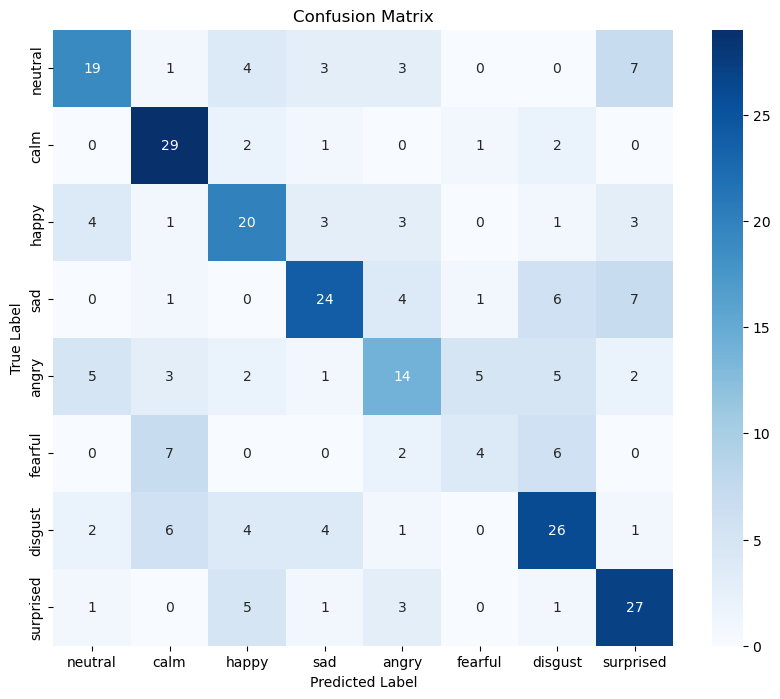

In [18]:
# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = list(emotions.values())

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
# Generate classification report
report = classification_report(y_val, y_pred, target_names=labels)
print(report)

              precision    recall  f1-score   support

     neutral       0.61      0.51      0.56        37
        calm       0.60      0.83      0.70        35
       happy       0.54      0.57      0.56        35
         sad       0.65      0.56      0.60        43
       angry       0.47      0.38      0.42        37
     fearful       0.36      0.21      0.27        19
     disgust       0.55      0.59      0.57        44
   surprised       0.57      0.71      0.64        38

    accuracy                           0.57       288
   macro avg       0.55      0.55      0.54       288
weighted avg       0.56      0.57      0.56       288



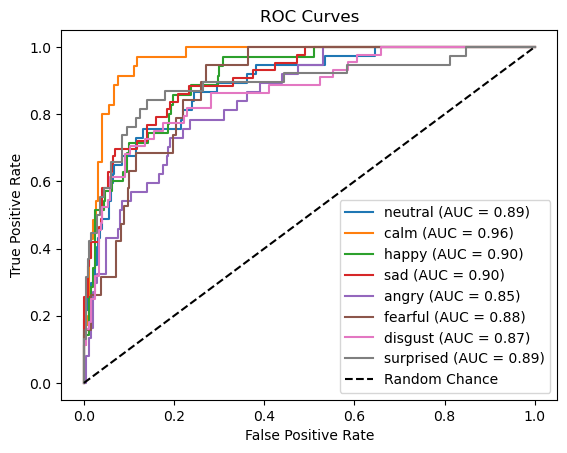

In [20]:
# Binarize labels for ROC-AUC
n_classes = len(labels)
y_val_bin = tf.keras.utils.to_categorical(y_val, num_classes=n_classes)
y_pred_bin = tf.keras.utils.to_categorical(y_pred, num_classes=n_classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()
